# Interpretability Techniques for single samples from FUNSD

## Github

In [2]:
!git clone https://github.com/adamserag1/Interpretability-for-VRDU-models.git

Cloning into 'Interpretability-for-VRDU-models'...
remote: Enumerating objects: 1562, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1562 (delta 51), reused 65 (delta 31), pack-reused 1472 (from 1)
Receiving objects: 100% (1562/1562), 21.33 MiB | 24.62 MiB/s, done.
Resolving deltas: 100% (990/990), done.


In [1]:
!git pull https://github.com/adamserag1/Interpretability-for-VRDU-models.git

fatal: not a git repository (or any of the parent directories): .git


In [3]:
%cd /content/Interpretability-for-VRDU-models

/content/Interpretability-for-VRDU-models


In [4]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install -U datasets

## Libraries

In [7]:
#code
from datasets import load_from_disk
from transformers import LayoutLMv3ForTokenClassification, AutoProcessor, BrosForTokenClassification, AutoTokenizer, AutoConfig
import sys
import importlib
def reload_modules():
    for module in list(sys.modules.keys()):
        if module.startswith('vrdu_utils') or module.startswith('Classification_Explain') or module.startswith('lime') or module.startswith('Eval'):
            print(f"Reloading module: {module}")
            importlib.reload(sys.modules[module])

reload_modules()

from vrdu_utils.encoders import *
from Classification_Explain.lime import *
from vrdu_utils.utils import *
import torch
from Eval.eval_suite import *
from Eval.fidelity import *
from Classification_Explain.shap import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
from transformers import logging as hf_logging

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="transformers.modeling_utils",   # the module that emits the msg
)
hf_logging.set_verbosity_error()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data & Model Setup

In [8]:
FUNSD = load_dataset("nielsr/funsd")
label_list = FUNSD["train"].features["ner_tags"].feature.names
id2label = {v:k for v,k in enumerate(label_list)}
label2id = {k:v for v,k in enumerate(label_list)}
funsd_test = FUNSD["test"]
test_ds = DocSampleDataset(funsd_test)
print(label_list)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/755 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/149 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [9]:
LLMV3 = LayoutLMv3ForTokenClassification.from_pretrained('adamadam111/layoutlmv3-finetuned-funsd', num_labels = len(label_list), id2label = id2label, label2id = label2id)
LLMV3_proc = AutoProcessor.from_pretrained('adamadam111/layoutlmv3-finetuned-funsd', apply_ocr=False)


BROS = BrosForTokenClassification.from_pretrained('adamadam111/bros-funsd-finetuned', num_labels = len(label_list), id2label = id2label, label2id = label2id)
BROS_t = AutoTokenizer.from_pretrained('adamadam111/bros-funsd-finetuned')

BROS.to(device)
LLMV3.to(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [10]:
LLMV3_encode = make_layoutlmv3_encoder(LLMV3_proc, ner=True)
BROS_encode = make_bros_encoder(BROS_t, ner=True)

## Finding Samples

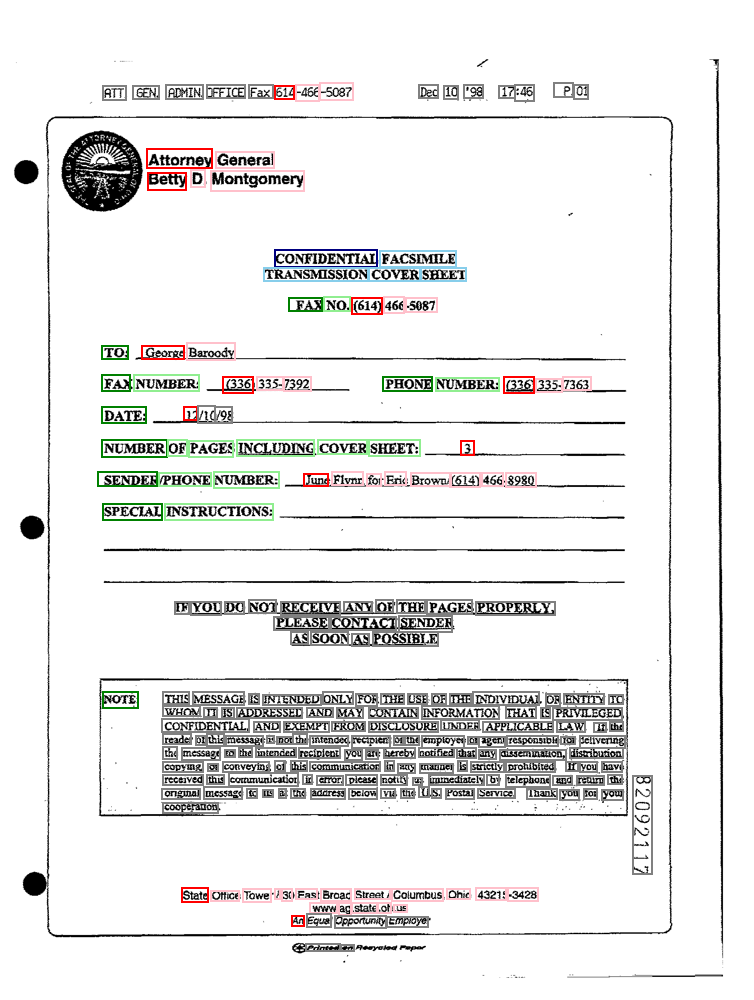

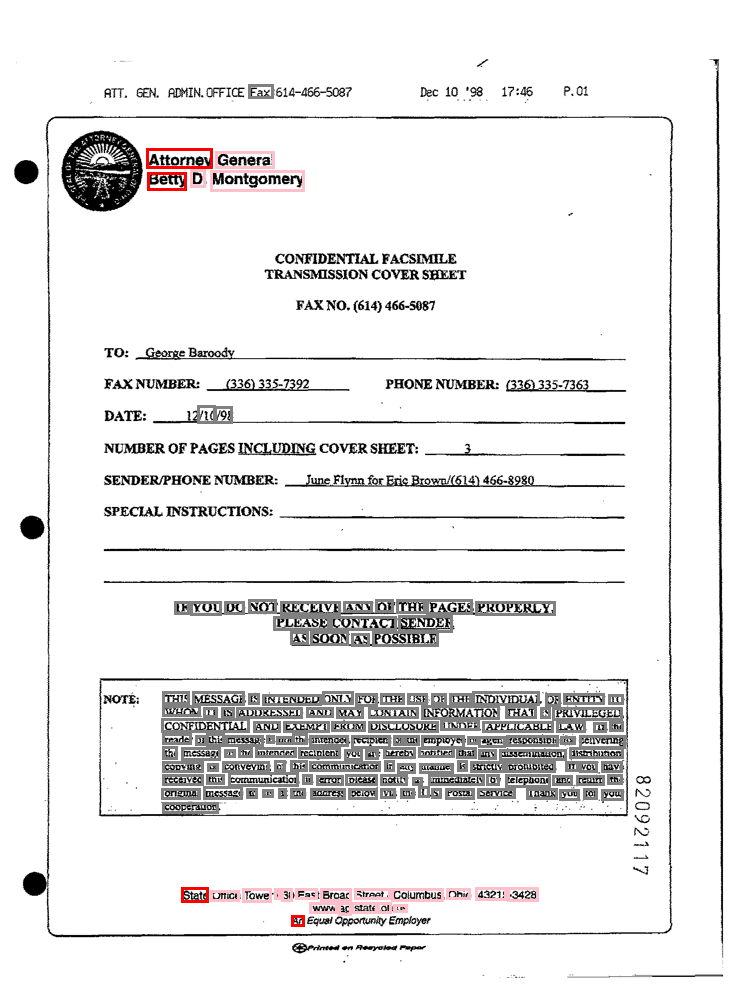

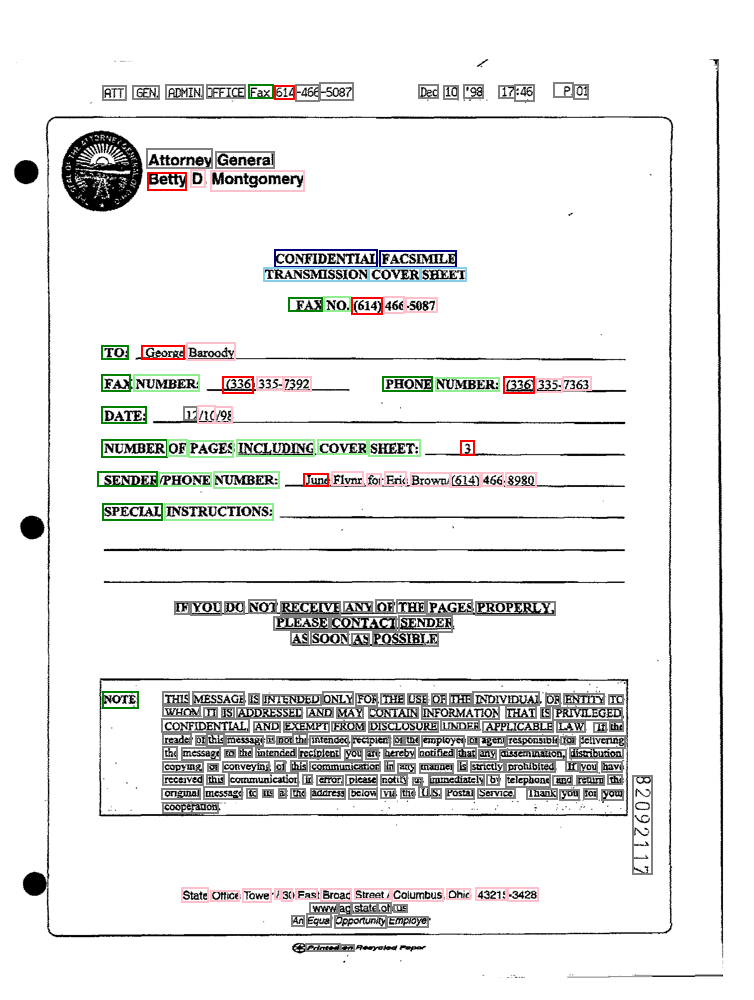

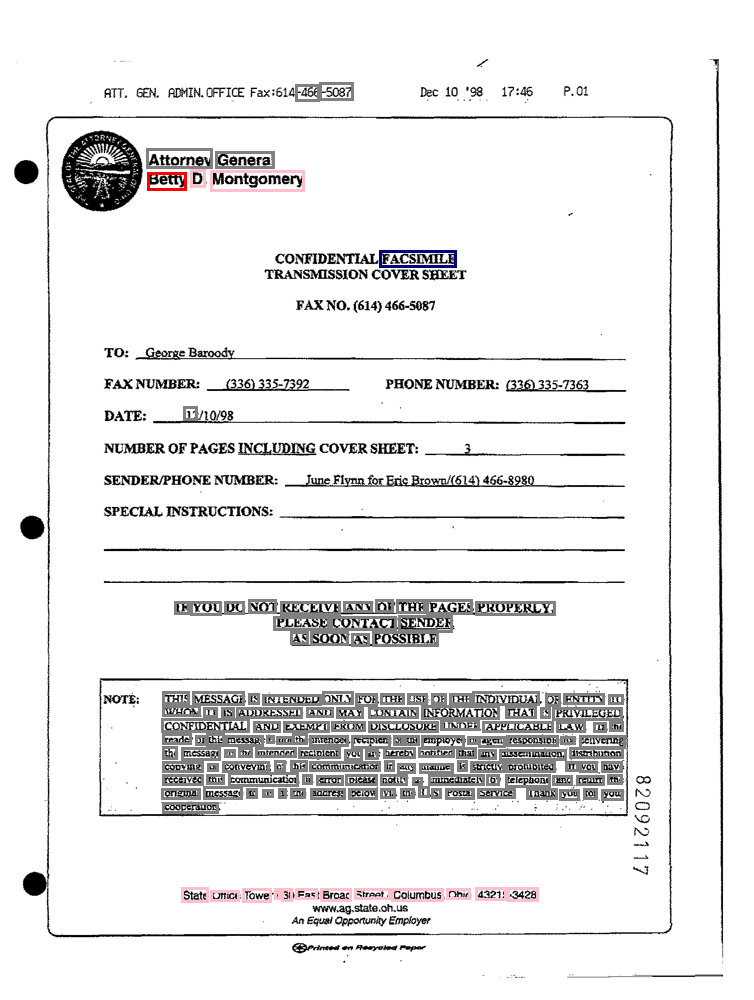

In [247]:
TAG_COLOURS = {
    "O":          "gray",
    "B-HEADER":   "navy",
    "I-HEADER":   "skyblue",
    "B-QUESTION": "green",
    "I-QUESTION": "lightgreen",
    "B-ANSWER":   "red",
    "I-ANSWER":   "pink",
}

# ──────────────────────────────────────────────────────────────────────────────
# 1️⃣  Helper: draw a single page with coloured boxes
# ──────────────────────────────────────────────────────────────────────────────
def draw_page_with_tags(img_path, bboxes, tag_names, tag_colours=TAG_COLOURS, width=2):
    """
    img_path  : path to the page image (png / jpg)
    bboxes    : list of [x1,y1,x2,y2] *pixel* boxes, one per word
    tag_names : list of str labels (same length as bboxes)
    width     : outline thickness
    returns   : PIL.Image with coloured rectangles
    """
    img = img_path.convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size
    bboxes = [unnormalize_box(bbox, w, h) for bbox in bboxes]
    for box, tag in zip(bboxes, tag_names):
        colour = tag_colours.get(tag, "black")       # fallback to black
        draw.rectangle(box, outline=colour, width=width)

    return img

# ──────────────────────────────────────────────────────────────────────────────
# 2️⃣  Helper: word-level predictions for ONE model on ONE sample
#     (uses your existing encode_fn + model)
# ──────────────────────────────────────────────────────────────────────────────
def _get_word_preds(sample, model, encode_fn, id2label, device="cuda"):
    """
    Word-level predictions perfectly aligned with sample['words'].
    – no double box-normalisation
    – no CLS/SEP leakage
    – robust to truncation
    """
    model.eval()

    # ❶ keep FUNSD boxes as-is (0-1000)
    ds = DocSample(
        image    = sample["image"],
        words    = sample["words"],
        bboxes   = sample["bboxes"],
        ner_tags = sample["ner_tags"],
    )

    # ❷ make sure encode_fn returns the *original* BatchEncoding
    enc, _ = encode_fn([ds], device)          # <-- enc is BatchEncoding, not dict
    enc.to(device)
    with torch.no_grad():
        logits = model(**enc).logits[0]     # (seq_len, n_labels)

    pred_ids = logits.argmax(-1).tolist()
    word_ids = enc.word_ids(batch_index=0)  # mapping sub-token → word-idx

    preds, prev_wid = [], None
    for tok_idx, wid in enumerate(word_ids):
        if wid is None or wid == prev_wid:     # skip CLS/SEP & extra subtokens
            continue
        preds.append(id2label[pred_ids[tok_idx]])
        prev_wid = wid
        if len(preds) == len(sample["ner_tags"]):   # stop if page was truncated
            break

    return preds
def visualise_error_boxes(
    sample,
    model_a, encode_a,
    model_b, encode_b,
    id2label,
    device="cpu",
):
    # predictions
    tags_a = _get_word_preds(sample, model_a, encode_a, id2label, device)
    tags_b = _get_word_preds(sample, model_b, encode_b, id2label, device)

    # ground-truth tag names
    gt_tags = [id2label[i] for i in sample["ner_tags"]]

    # images that highlight ONLY the mistakes
    err_a = draw_page_errors(sample["image"], sample["bboxes"],
                             tags_a, gt_tags)
    err_b = draw_page_errors(sample["image"], sample["bboxes"],
                             tags_b, gt_tags)

    return err_a, err_b

def draw_page_errors(img,
                     bboxes,
                     pred_tags,
                     gt_tags,
                     tag_colours=TAG_COLOURS,
                     width=3):
    """
    Like draw_page_with_tags, but draws a rectangle *only* when
    pred_tags[i] != gt_tags[i].
    The outline colour still reflects the model’s **predicted** tag.
    """
    canvas = img.convert("RGB").copy()
    draw   = ImageDraw.Draw(canvas)
    W, H   = canvas.size
    pix_boxes = [unnormalize_box(b, W, H) for b in bboxes]

    for box, p_tag, g_tag in zip(pix_boxes, pred_tags, gt_tags):
        if p_tag != g_tag:                       # model got it wrong
            colour = tag_colours.get(p_tag, "black")
            draw.rectangle(box, outline=colour, width=width)

    return canvas

# ──────────────────────────────────────────────────────────────────────────────
# 3️⃣  Main routine: run two models, return two coloured images
# ──────────────────────────────────────────────────────────────────────────────
def visualise_two_models(
    sample,                              # dict or DocSample
    model_a, encode_a,                   # first model + encoder
    model_b, encode_b,                   # second model + encoder
    id2label,                            # id → tag string map
    device="cpu",
):
    # predictions
    tags_a = _get_word_preds(sample, model_a, encode_a, id2label, device)
    tags_b = _get_word_preds(sample, model_b, encode_b, id2label, device)

    # coloured pages
    img_a  = draw_page_with_tags(sample["image"], sample["bboxes"], tags_a)
    img_b  = draw_page_with_tags(sample["image"], sample["bboxes"], tags_b)

    return img_a, img_b


page = FUNSD["test"][0]                        # or your DocSample instance

img_llmv3, img_bros = visualise_two_models(
    page,
    LLMV3, LLMV3_encode,
    BROS , BROS_encode,
    id2label,
    device=device,
)

# NEW: error-only overlays
err_llmv3, err_bros = visualise_error_boxes(
    page, LLMV3, LLMV3_encode, BROS, BROS_encode, id2label, device=device
)

display(img_llmv3)      # all predictions from model A
display(err_llmv3)      # only the wrong ones from model A
display(img_bros)       # all predictions from model B
display(err_bros)

# TAG_COLOURS = {
#     "O":          "gray",
#     "B-HEADER":   "navy",
#     "I-HEADER":   "skyblue",
#     "B-QUESTION": "green",
#     "I-QUESTION": "lightgreen",
#     "B-ANSWER":   "red",
#     "I-ANSWER":   "pink",
# }


In [11]:
expample = FUNSD['test'][0]
example = DocSample(
        image    = expample["image"],
        words    = expample["words"],
        bboxes   = expample["bboxes"],
        ner_tags = expample["ner_tags"],
    )
target_word = 'FAX'
for i,t in enumerate(example.words):
  if t == target_word:
    target_idx = i

def target_token_fn(enc, *, batch_index: int = 0) -> int:
  word_ids = enc.word_ids(batch_index=batch_index)

  for tok_idx, wid in enumerate(word_ids):
      if wid == 40:
          return tok_idx

target_label = label2id['B-QUESTION']
target_label

3

## Text

In [14]:
text_explainers = {
    'LLMV3 lime' : LimeTextNer(LLMV3, LLMV3_encode, mask_token=LLMV3_proc.tokenizer.mask_token, device = device, kernel_width_factor=0.75, labels=[target_label],target_token_fn=target_token_fn, target_labels=target_label),
    'LLMV3 shap' : SHAPTextNer(LLMV3, LLMV3_encode, tokenizer=LLMV3_proc.tokenizer, mask_token=LLMV3_proc.tokenizer.mask_token, device = device, target_token_fn=target_token_fn, target_labels=target_label),
    'BROS lime' : LimeTextNer(BROS, BROS_encode, mask_token=BROS_t.mask_token, device = device, kernel_width_factor=0.75, target_token_fn=target_token_fn, target_labels=target_label),
    'BROS shap' : SHAPTextNer(BROS, BROS_encode, tokenizer=BROS_t ,mask_token=BROS_t.mask_token, device = device, target_token_fn=target_token_fn, target_labels=target_label),
}


In [301]:
print(example)

DocSample(image=<PIL.PngImagePlugin.PngImageFile image mode=L size=754x1000 at 0x7E14EF698410>, words=['TO:', 'DATE:', '3', 'Fax:', 'NOTE:', '82092117', '614', '-466', '-5087', 'Dec', '10', "'98", '17', ':46', 'P.', '01', 'ATT.', 'GEN.', 'ADMIN.', 'OFFICE', 'Attorney', 'General', 'Betty', 'D.', 'Montgomery', 'CONFIDENTIAL', 'FACSIMILE', 'TRANSMISSION', 'COVER', 'SHEET', '(614)', '466-', '5087', 'FAX', 'NO.', 'George', 'Baroody', '(336)', '335-', '7392', 'FAX', 'NUMBER:', 'PHONE', 'NUMBER:', '(336)', '335-', '7363', 'NUMBER', 'OF', 'PAGES', 'INCLUDING', 'COVER', 'SHEET:', 'June', 'Flynn', 'for', 'Eric', 'Brown/', '(614)', '466-', '8980', 'SENDER', '/PHONE', 'NUMBER:', 'SPECIAL', 'INSTRUCTIONS:', 'IF', 'YOU', 'DO', 'NOT', 'RECEIVE', 'ANY', 'OF', 'THE', 'PAGES', 'PROPERLY,', 'PLEASE', 'CONTACT', 'SENDER', 'AS', 'SOON', 'AS', 'POSSIBLE', 'THIS', 'MESSAGE', 'IS', 'INTENDED', 'ONLY', 'FOR', 'THE', 'USE', 'OF', 'THE', 'INDIVIDUAL', 'OR', 'ENTITY', 'TO', 'WHOM', 'IT', 'IS', 'ADDRESSED', 'AND',

In [13]:
temp = text_explainers['LLMV3 lime'].explain(example)

Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT


[LIME] - Text: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s]
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


IndexError: index 1 is out of bounds for axis 1 with size 1